# Projets classification de paysages : Observer les sorties convolutionnelles

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
from os import listdir, mkdir, rename
from os.path import isfile, join
from PIL import Image
import random as rnd
import torch
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch import nn
from torch.utils.data import ConcatDataset, random_split, DataLoader
import numpy as np
from zipfile import ZipFile
from sklearn.metrics import accuracy_score
import requests
import io
import tempfile
import matplotlib.pyplot as plt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Constantes

In [2]:
folders = False
dataPath = '/content/data_paysages'

trainPath = join(dataPath, 'seg_train')
testPath = join(dataPath, 'seg_test')
predPath = join(dataPath, 'seg_pred')

zipPath = '/content/gdrive/My Drive/datas/data_paysages.zip'
weightFile = '/content/gdrive/My Drive/datas/weight_classif_paysage.pt'
rootPath = '/content/'
batchSize = 128
usePretrained = True
trainModel = False
testModel = True

colorMap = 'jet'

# Dézippage + classes

In [3]:
zip_ref = ZipFile(zipPath, "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
classes = os.listdir(trainPath)
classes.sort()
idx_to_class = {i: classes[i] for i in range(len(classes))}

print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Fonctions

## training

In [5]:
def training(model, train_dataloader, valid_dataloader=None, epoch=5, learning_rate=0.1, use_gpu=False, weight_file=None):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  train_accu = []
  train_losses = []
  
  if valid_dataloader:
    val_accu = []
    val_loss = []
    
  for i in range(epoch):
    model.train()
    
    print('Starting epoch number {} on {} ...'.format(i+1, epoch))
    
    true = []
    pred = []
    train_loss = []
    len_train = len(train_dataloader)
    for ind, batch in enumerate(train_dataloader):
      print('\rBatch : {}/{}'.format(ind+1, len_train), end='')
      inputs, targets = batch
      
      # Aller le GPU, fais ton taff
      if use_gpu:
        inputs = inputs.cuda()
        targets = targets.cuda()
      
      optimizer.zero_grad()
        
      outputs = model(inputs)
      
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      
      predictions = outputs.max(dim=1)[1]
      
      train_loss.append(loss.item())
      true.extend(targets.data.cpu().numpy().tolist())
      pred.extend(predictions.data.cpu().numpy().tolist())
    
    accu_score = accuracy_score(true, pred) * 100
    loss_score = sum(train_loss) / len(train_loss)
    
    
    train_accu.append(accuracy_score(true, pred) * 100)
    train_losses.append(loss_score)

    if weight_file:
      torch.save(model.state_dict(), weight_file)
      
    if valid_dataloader:
      vaccu, vloss = validating(model, valid_dataloader, use_gpu)
      val_accu.append(vaccu)
      val_loss.append(vloss)
    else:
      print()
    
    print('\nTrain score : Accuracy = {:.2f} - Loss = {:.2f} | Validation score : Accuracy = {:.2f} - Loss = {:.2f}'.format(accu_score, loss_score, vaccu, vloss))
  
  if valid_dataloader:
    return train_accu, train_losses, val_accu, val_loss
  else:
    return train_accu, train_loss
  
  return None, None

## validating

In [6]:
def validating(model, dataloader, use_gpu=False):
  true =[]
  pred = []
  val_loss = []
  len_valid = len(dataloader)
  ind = 0

  criterion = nn.CrossEntropyLoss()
  model.eval()

  for batch in dataloader:
    print('\rValidation Batch : {}/{}'.format(ind+1, len_valid), end='')

    inputs, targets = batch

    # On envoit les données au GPU pour le traitement
    if use_gpu:
      inputs = inputs.cuda()
      targets = targets.cuda()
    
    outputs = model(inputs)

    predictions = outputs.max(dim=1)[1]

    val_loss.append(criterion(outputs, targets).item())
    true.extend(targets.data.cpu().numpy().tolist())
    pred.extend(predictions.data.cpu().numpy().tolist())
    ind += 1
  
  accu_score = accuracy_score(true, pred) * 100
  loss_score = sum(val_loss) / len(val_loss)
  return accu_score, loss_score

## testing

In [7]:
# Réutilisation du code de validation en soi (chut c'est un secret)
def testing(model, dataloader, use_gpu=False):
  model = model.cuda()
  true =[]
  pred = []
  test_loss = []
  len_test = len(dataloader)
  ind = 0

  criterion = nn.CrossEntropyLoss()
  model.eval()

  for batch in dataloader:
    print('\rTesting Batch : {}/{}'.format(ind+1, len_test), end='')

    inputs, targets = batch

    if use_gpu:
      inputs = inputs.cuda()
      targets = targets.cuda()
    
    outputs = model(inputs)
    predictions = outputs.max(dim=1)[1]

    test_loss.append(criterion(outputs, targets).item())
    true.extend(targets.data.cpu().numpy().tolist())
    pred.extend(predictions.data.cpu().numpy().tolist())
    ind += 1
  
  accu_score = accuracy_score(true, pred) * 100
  loss_score = sum(test_loss) / len(test_loss)
  print(f'\nAccuracy : {accu_score:0.2f}% - Loss : {loss_score:0.2f}')
  return accu_score, loss_score

## predict

In [8]:
def predict(model, data):
  model.eval()
  output = model(data)
  prediction = output.max(dim=1)[1]
  return prediction

## get_my_representations

In [9]:
def get_my_representations(model, img_tensor):
  conv1 = model.conv1.forward(img_tensor)
  y = model.bn1.forward(conv1)
  y = model.relu.forward(y)
  y = model.maxpool.forward(y)
  layer1 = model.layer1.forward(y)
  layer2 = model.layer2.forward(layer1)
  layer3 = model.layer3.forward(layer2)
  layer4 = model.layer4.forward(layer3)
  return conv1.squeeze(), layer1.squeeze(), layer2.squeeze(), layer3.squeeze(), layer4.squeeze()

## get_img_by_url

In [19]:
def get_img_by_url(url):
  buffer = tempfile.SpooledTemporaryFile(max_size=1e9)
  r = requests.get(url, stream=True)
  if r.status_code == 200:
      downloaded = 0
      filesize = int(r.headers['content-length'])
      for chunk in r.iter_content():
          downloaded += len(chunk)
          buffer.write(chunk)
      buffer.seek(0)
      img = Image.open(io.BytesIO(buffer.read()))
      # img.save(os.path.join(rootPath, 'image.jpg'), quality=85)
  buffer.close()
  return img

# Traitement

In [10]:
# Bout de code pour vérifier la largeur et la longueur max d'une image (pour un resize)
subDir = listdir(trainPath)

allImages = []
for sub in subDir:
  for imgFile in listdir(join(trainPath, sub)):
    imgPath = join(trainPath, sub, imgFile)
    allImages.append(imgPath)

allWidths = []
allHeights = []
for image in allImages:
  img = Image.open(image)
  width = img.size[0]
  height = img.size[1]
  allWidths.append(width)
  allHeights.append(height)

print(f"All different widths : {set(allWidths)}")
print(f"All different heights : {set(allHeights)}")
maxWidth = max(allWidths)
maxHeight = max(allHeights)
print(f"\nMax width : {maxWidth} - Max height : {maxHeight}")

All different widths : {150}
All different heights : {131, 133, 134, 135, 136, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 76, 81, 97, 100, 102, 103, 105, 108, 110, 111, 113, 115, 119, 120, 123, 124}

Max width : 150 - Max height : 150


In [11]:
# Création du dataset : Occupons nous du cas ou nous essayons de classifier les images selon leur marque directement
trans = transforms.Compose([
    transforms.Resize(size=(maxHeight, maxWidth)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
augmented_trans = transforms.Compose([
    transforms.Resize(size=(maxHeight, maxWidth)),
    transforms.RandomRotation((0, 180)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
normal_trans = transforms.Compose([
    transforms.Resize(size=(maxHeight, maxWidth)),
    transforms.ToTensor()
])

base_dataset = torchvision.datasets.ImageFolder(
        root=trainPath,
        transform=trans)
trans_dataset = torchvision.datasets.ImageFolder(
    root=trainPath,
    transform=augmented_trans
)
dataset = ConcatDataset([base_dataset, trans_dataset])

test_dataset = torchvision.datasets.ImageFolder(
    root=testPath,
    transform=normal_trans
)

# On veut 80% pour l'entrainement, 10% pour la validation et 10% pour les tests
train_length = int(0.9*len(dataset))
valid_length = len(dataset)-train_length

train_set, valid_set = random_split(dataset, [train_length, valid_length])

# On crée nos DataLoaders
train_loader = DataLoader(train_set, batch_size=batchSize, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=batchSize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

In [12]:
if usePretrained:
  model = models.resnet18(pretrained=False)
  model.fc = nn.Linear(in_features=512, out_features=len(np.unique(base_dataset.targets)))
  model.load_state_dict(torch.load(weightFile))
else:
  # On charge le ResNet18
  model = models.resnet18(pretrained=True)
  model.fc = nn.Linear(in_features=512, out_features=len(np.unique(base_dataset.targets)))
  # On veut classer selon les 42 marques de voitures
  # print(model)
  model = model.cuda()

# Entrainement

In [13]:
if trainModel:
  accuTrain, lossTrain, accuValid, lossValid = training(model, train_loader, valid_loader, epoch=5, learning_rate=0.01, use_gpu=True, weight_file=weightFile)

# Tests et Prédictions

## Test

In [14]:
if testModel:
  accuTest, lossTest = testing(model, test_loader, use_gpu=True)
  model = model.cpu()

Testing Batch : 24/24
Accuracy : 88.87% - Loss : 0.31


## Utilisation d'une image

In [21]:
glacierUrl = "https://www.sciencealert.com/images/2019-11/processed/andes_glacier_1024.jpg"
imgGlacier = get_img_by_url(glacierUrl)

streetUrl = "https://static01.nyt.com/images/2020/04/13/nyregion/00nyvirus-streets001/00nyvirus-streets001-videoSixteenByNineJumbo1600.jpg"
imgStreet = get_img_by_url(streetUrl)

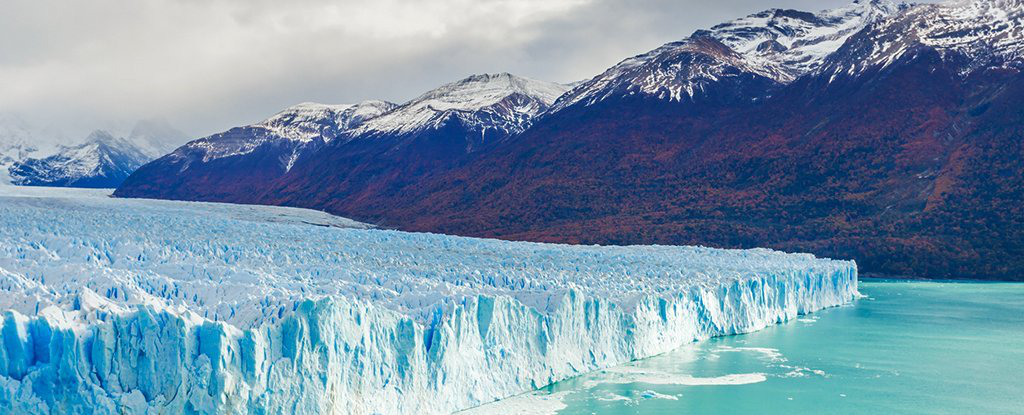

In [22]:
# On affiche seulement l'image
imgGlacier

In [23]:
imgStreet

Output hidden; open in https://colab.research.google.com to view.

## Prédiction de l'image téléchargée

In [27]:
img = imgGlacier.resize((maxWidth, maxHeight))
imgGlacierTensor = transforms.ToTensor()(img).unsqueeze(0)
imgClass = idx_to_class[predict(model, imgTensor).item()]
imgClass

'street'

In [28]:
img = imgStreet.resize((maxWidth, maxHeight))
imgStreetTensor = transforms.ToTensor()(img).unsqueeze(0)
imgClass = idx_to_class[predict(model, imgTensor).item()]
imgClass

'street'

# Analyse des filtres

## Première convolution

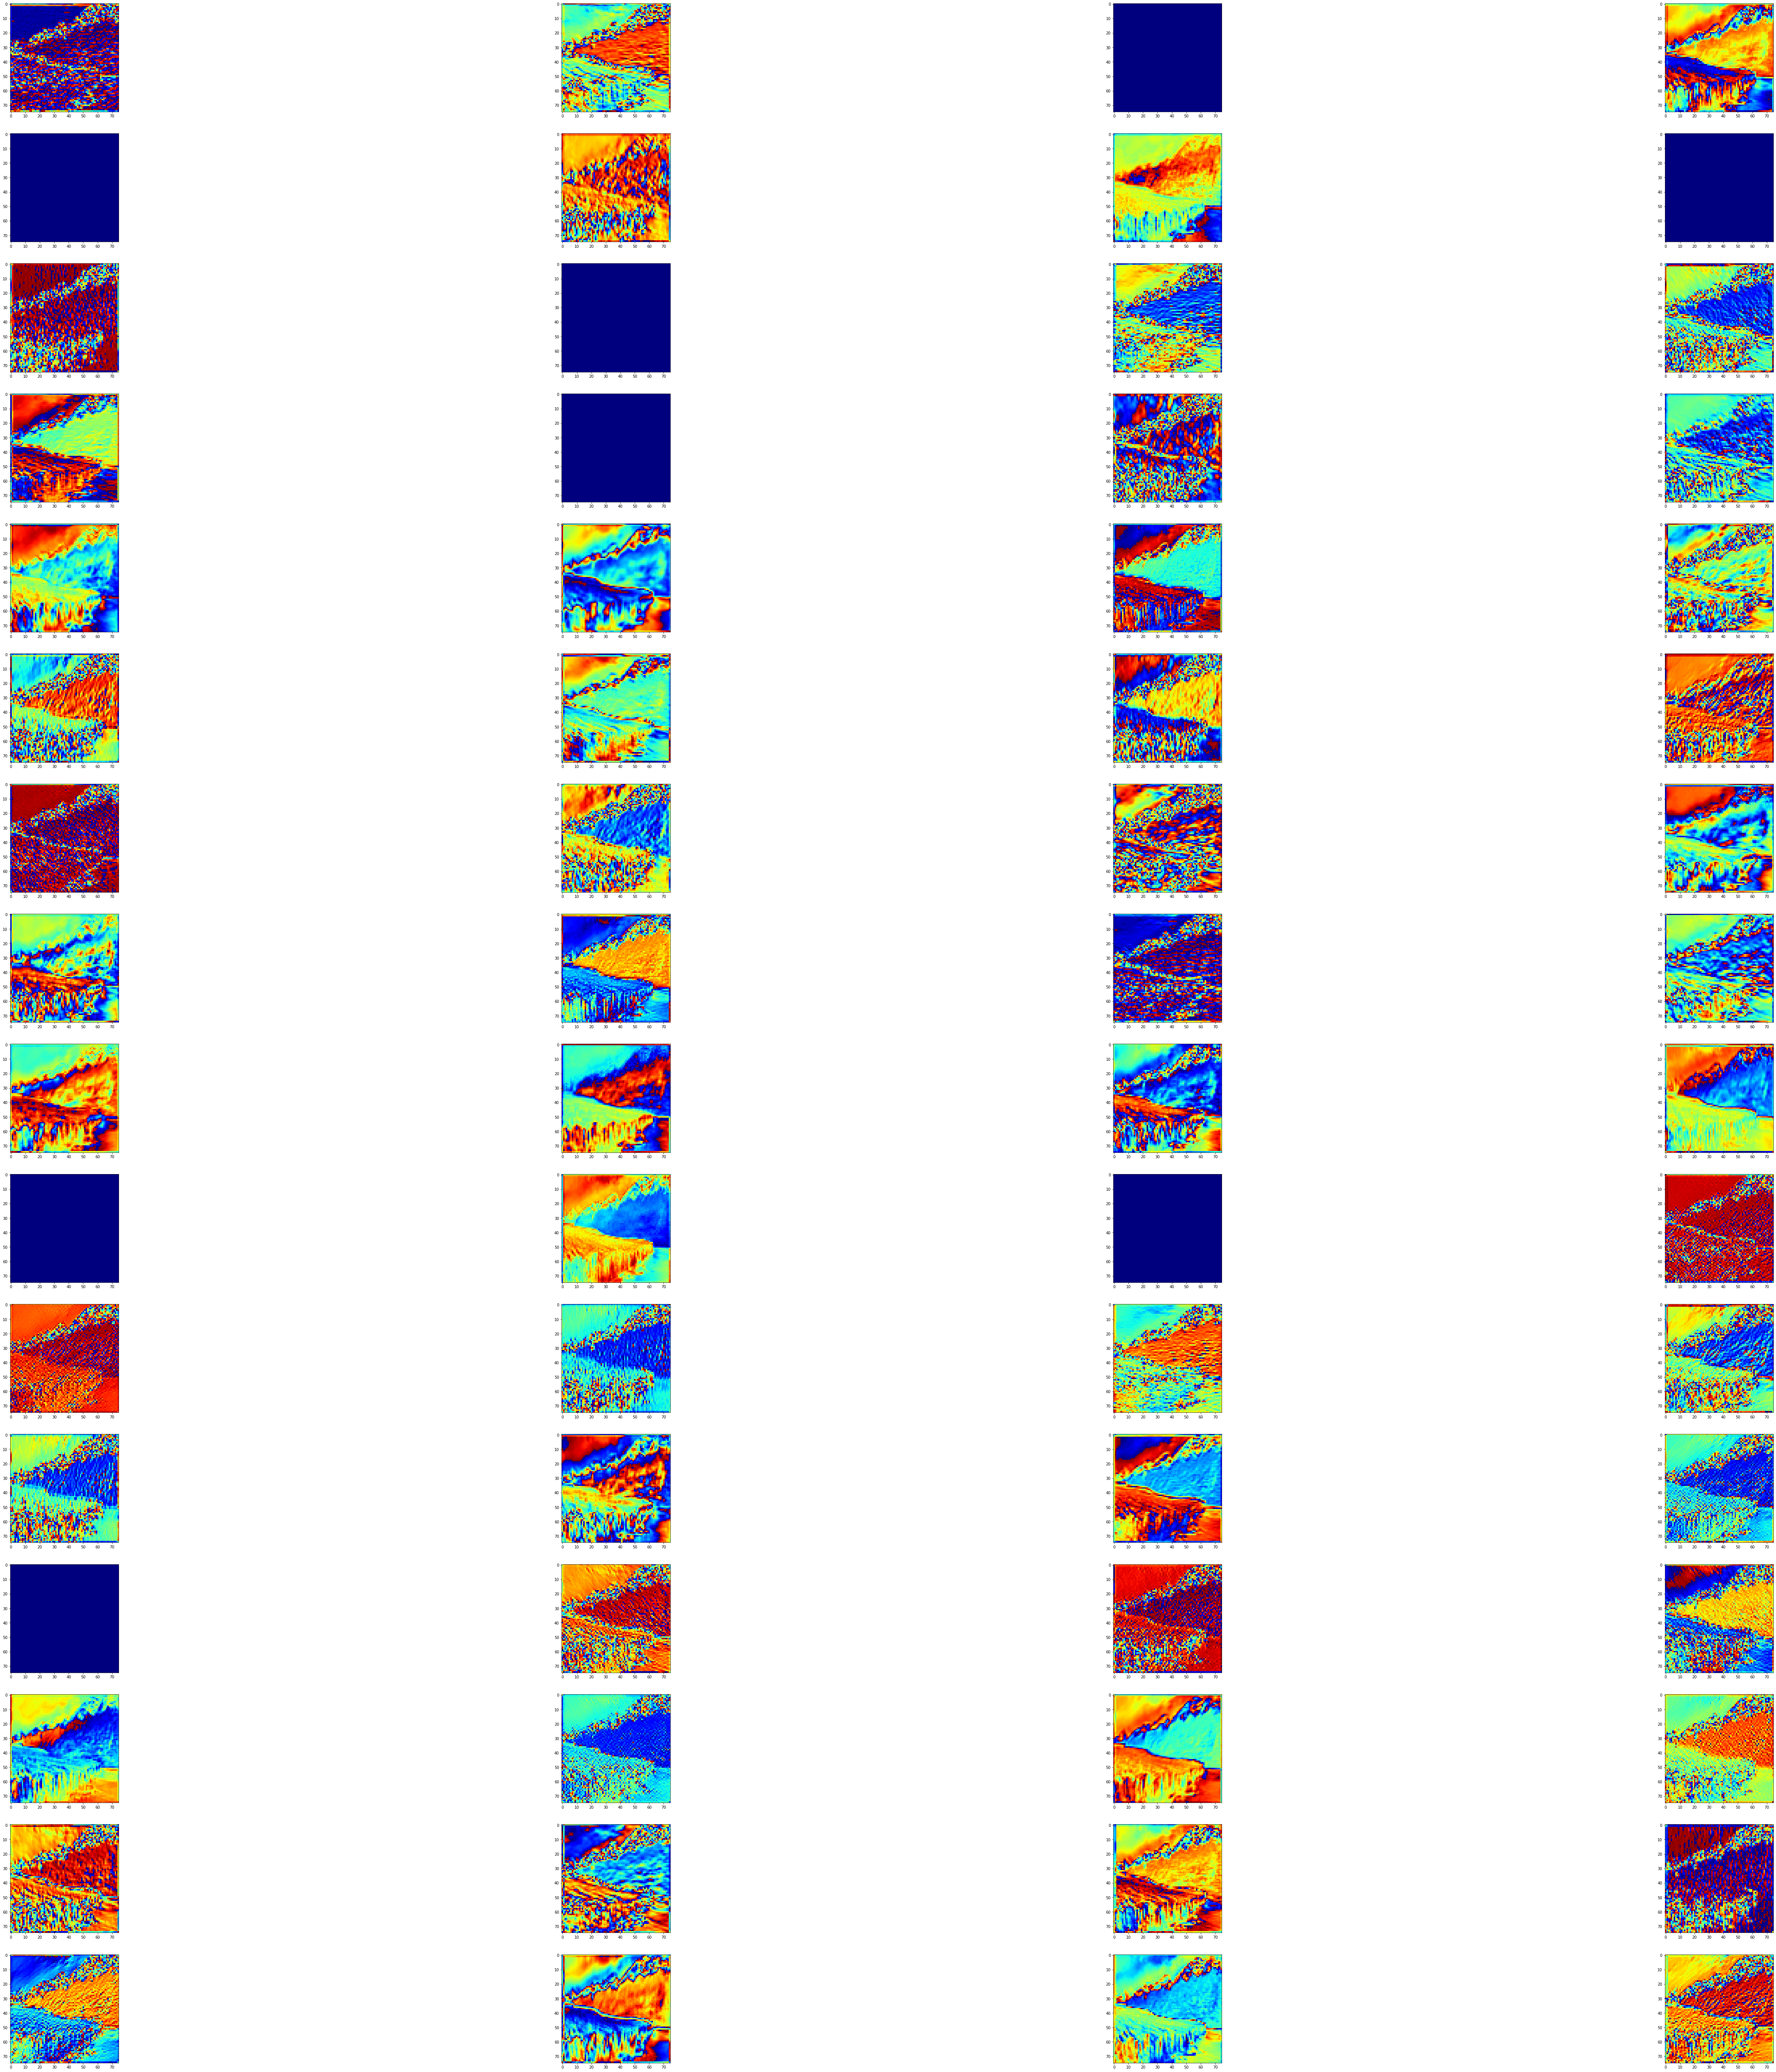

In [29]:
conv1, layer1, layer2, layer3, layer4 = get_my_representations(model, imgGlacierTensor)
fig, axes = plt.subplots(16, 4, figsize=(100, 100))
cnt = 0
for i in range(16):
  for j in range(4):
    convImg = transforms.ToPILImage()(conv1[cnt])
    axes[i, j].imshow(convImg, cmap=colorMap)
    cnt += 1
fig.savefig('conv1.png')

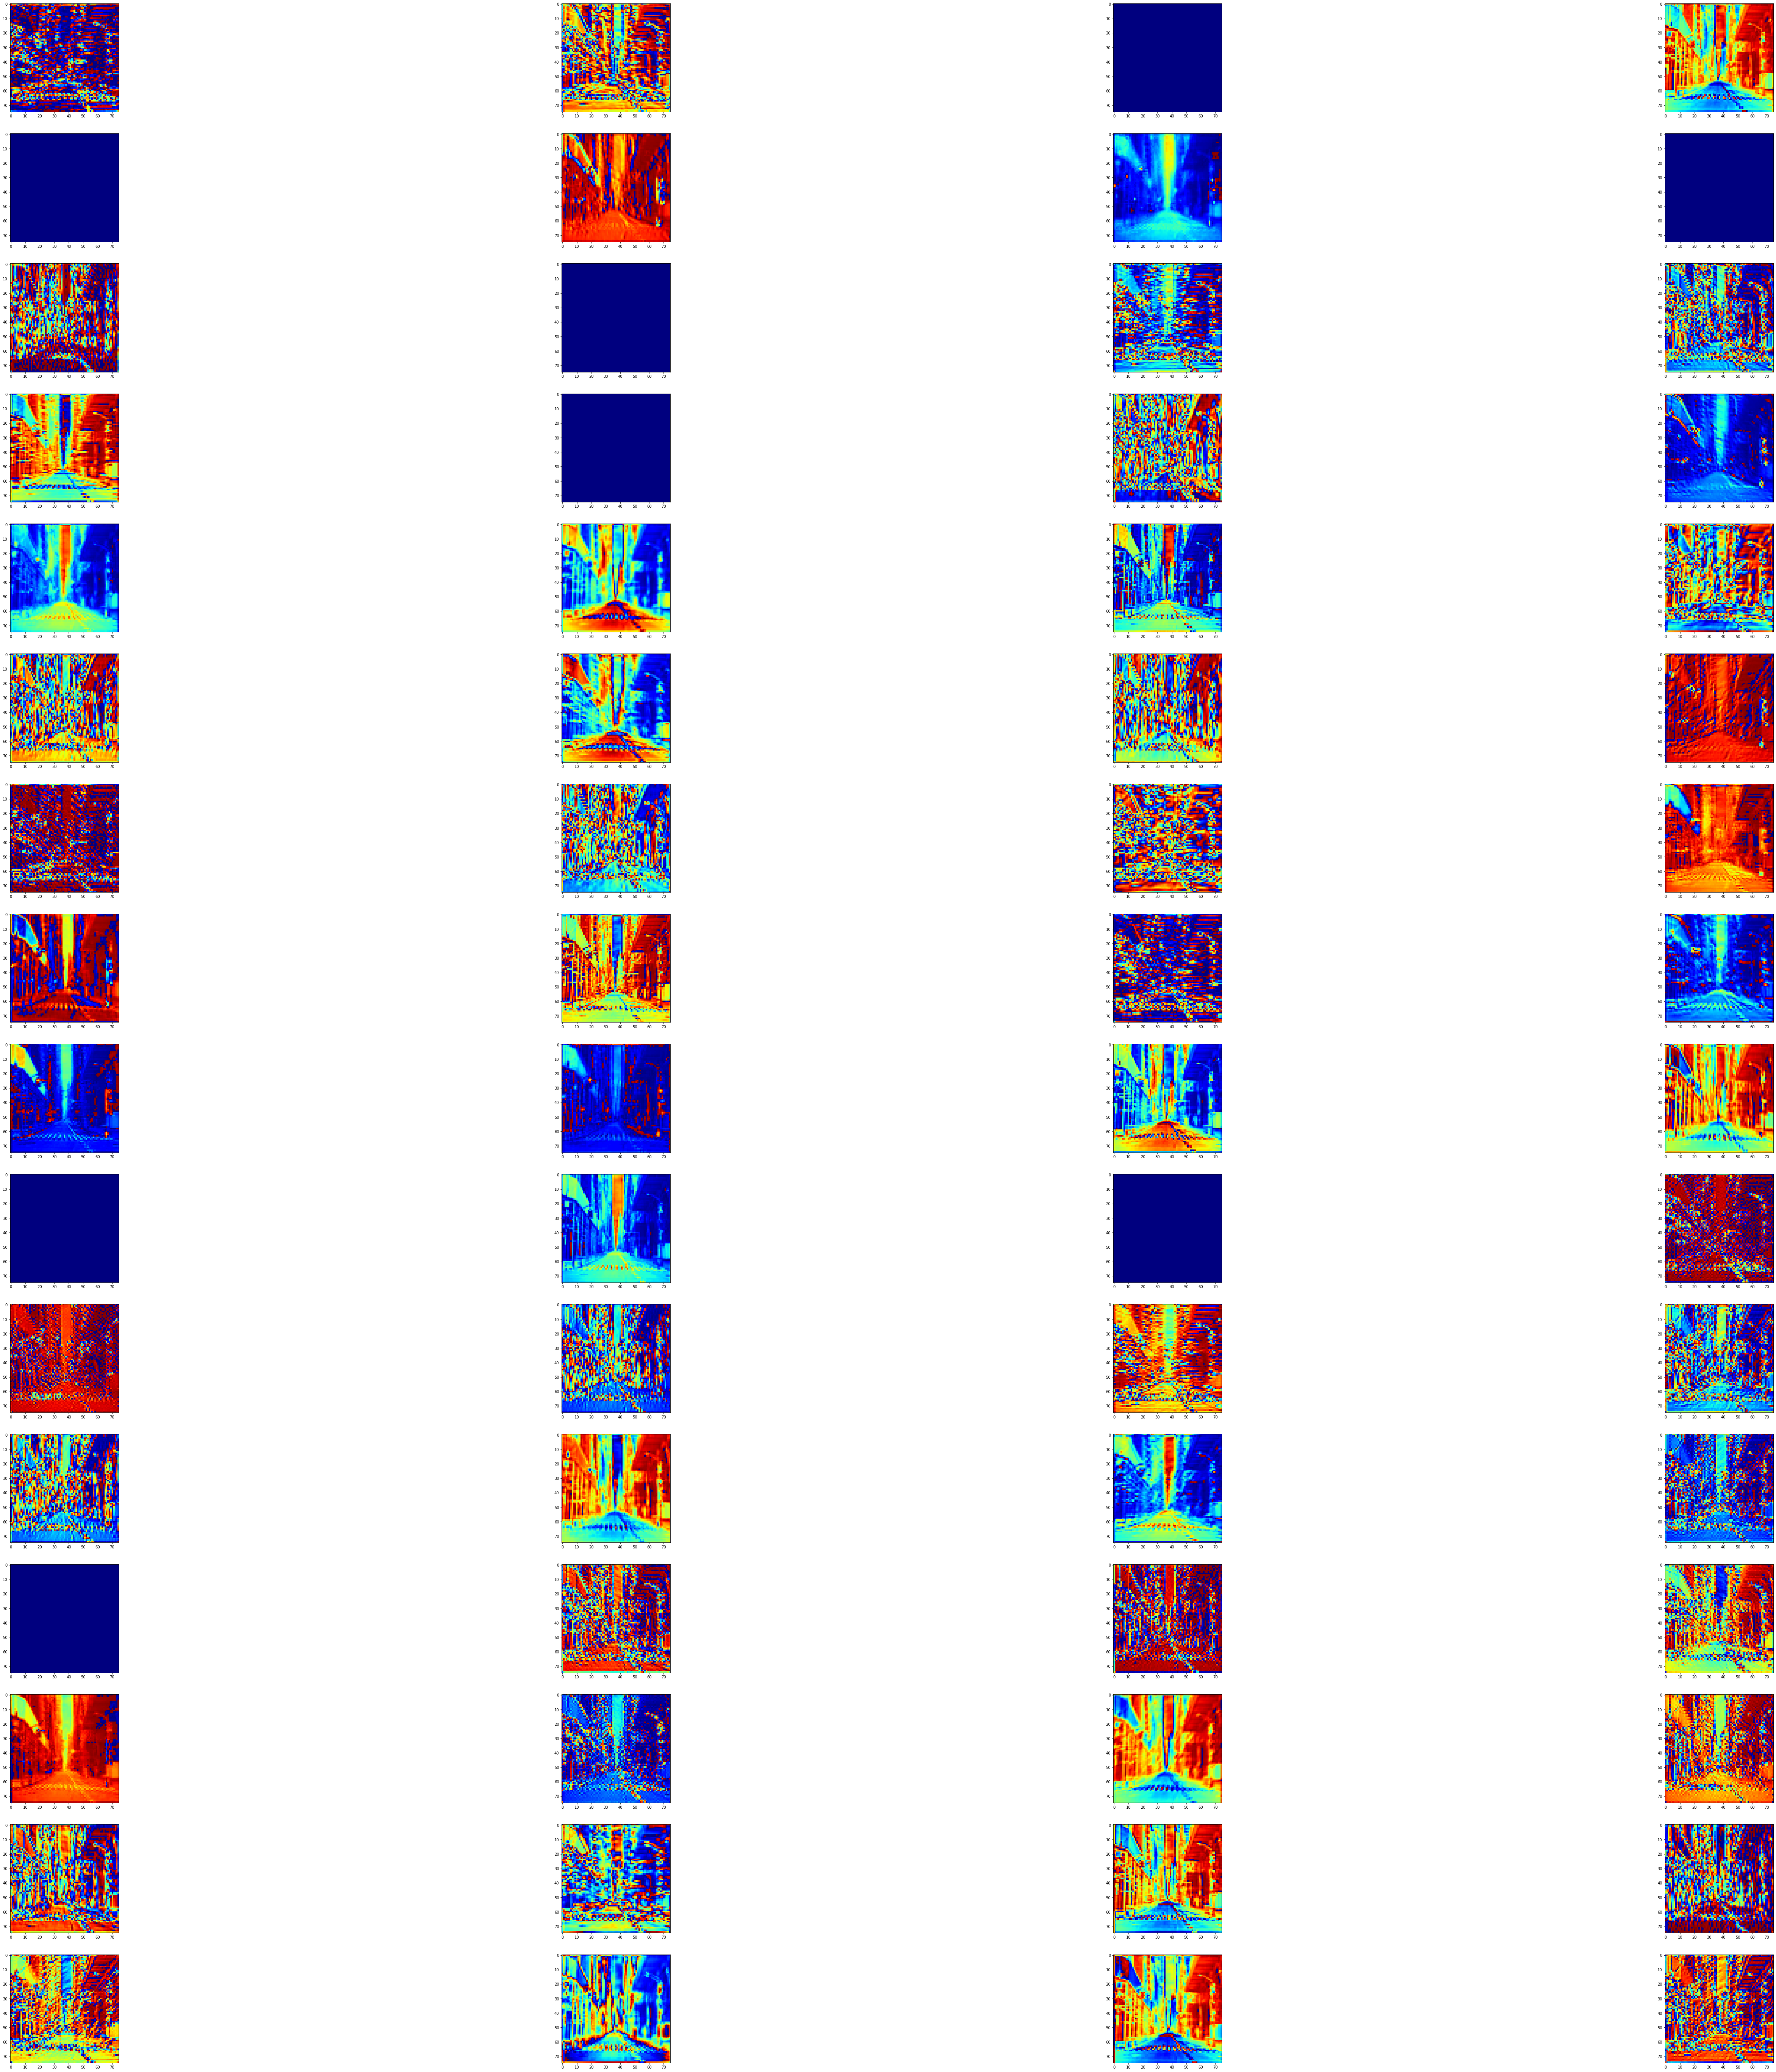

In [30]:
conv1, layer1, layer2, layer3, layer4 = get_my_representations(model, imgStreetTensor)
fig, axes = plt.subplots(16, 4, figsize=(100, 100))
cnt = 0
for i in range(16):
  for j in range(4):
    convImg = transforms.ToPILImage()(conv1[cnt])
    axes[i, j].imshow(convImg, cmap=colorMap)
    cnt += 1
fig.savefig('conv1.png')